This Jupyter notebook is intended to replicate the some of the analyses of results of the experiments conducted in the study by Sidulova et al. (2023). Compared to the implementation used for Sidulova et al. (2023), this notebook is utilizing the enhanced and restructured *DomId* Python library. It is important to acknowledge that there may be slight variations in the results when compared to the original study, primarily due to the non-fixed random seed which introduces an element of stochastic variability.

Sidulova, M., Sun, X., & Gossmann, A. (2023). Deep Unsupervised Clustering for Conditional Identification of Subgroups Within a Digital Pathology Image Set. In H. Greenspan, A. Madabhushi, P. Mousavi, S. Salcudean, J. Duncan, T. Syeda-Mahmood, & R. Taylor (Eds.), Medical Image Computing and Computer Assisted Intervention – MICCAI 2023 (Vol. 14227, pp. 666–675). Springer Nature Switzerland. https://doi.org/10.1007/978-3-031-43993-3_64

In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
from sklearn.manifold import TSNE

In [2]:
HER2_PATH_BASEPATH = '/storage6T/HER2/'
HER2_PATH = '/storage6T/HER2/Testing_fixed/categorized/combined_train/'

In [3]:
#Please insert yout path to the directory with the csv file associated with HER2 data (that contains scores)
base_path = HER2_PATH_BASEPATH
scores = pd.read_csv(
    os.path.join(base_path, "truthfile_002.csv"),
    names=["num", "file name", "s1", "s2", "s3", "s4", "s5", "s6", "s_7"],
)

Specify the directories with the experimental results for the three experiments:

In [4]:
# ex1 = './2024-04-16_17:15:40.338172_her2_vade/'  # vade
# ex2 = './2024-04-16_18:23:41.357723_her2_vade/'  # cdvade
# ex3 = './2024-04-16_17:49:57.887274_her2_dec/'   # dec

ex1 = './2024-04-17_09:30:14.239867_her2_vade/'  # vade
ex2 = './2024-04-17_10:39:22.988349_her2_vade/'  # cdvade
ex3 = './2024-04-17_10:05:16.944029_her2_dec/'   # dec

# number_predicted_domains = 3  # enter d_dim
colors = ["powderblue","cadetblue", "teal" ]

### Helper functions

In [5]:
def load_files(path):
    df = pd.read_csv(path+'clustering_results.csv')
    
    domain = df['predictions'].values
    
    vec_d = df['vec_d_labels'].values
    vec_y = df['vec_y_labels'].values
    img_locs = df['image_id_labels'].values

    Z = np.load(path + "Z_space.npy")

    #args = np.loadtxt(path + "arguments.txt", dtype=str, usecols=0)  # , delimiter = '\n')
    #img_locs = np.loadtxt(path + "img_id.txt", dtype=str)
    
    return domain, vec_d, vec_y, img_locs

In [6]:
def mean_scores_per_experiment(scores, img_locs):
    """
    Parser to get mean scores per image from the cvs file.
    The name of the images in the folders are slightly different from the names in the csv file.

    """

    M = []

    for prediction in img_locs:
        try:
            prediction = str(
                prediction.split("/")[-1]
            )  # depending if the path is full or not, take the img name only
        except:
            "not full path"

        if "s" in prediction:

            N = len(prediction) - 4 - 5
            # print(N, prediction[:N])
            # print(scores.loc[scores['file name'].str.contains(prediction[:N])])
            mean_score = scores.loc[
                scores["file name"].str.contains(prediction[:N])
            ].mean(axis=1, numeric_only=True)
        if "S" in prediction:

            N = len(prediction) - 4 - 5
            # print(N, prediction[:N])
            # print(scores.loc[scores['file name'].str.contains(prediction[:N])])
            mean_score = scores.loc[
                scores["file name"].str.contains(prediction[:N])
            ].mean(axis=1, numeric_only=True)
        else:
            N = len(prediction) - 6
            # print('secod case', N, prediction[:N])
            # print(scores.loc[scores['file name'].str.contains(prediction[:N])])
            mean_score = scores.loc[
                scores["file name"].str.contains(prediction[:N])
            ].mean(axis=1, numeric_only=True)
            # print(mean_score)
        mean_score = float(mean_score)
        # print(mean_score)
        M.append(mean_score)
    return M

In [7]:
def box_plot_per_domain(domain, M, fs, c, title, up, true_ex=False):
    """
    Box plot for median scores
    domain - predicted domain
    M - corresponding mean scores
    c - color fill for the box plot
    title - title of the experiment
    up - vertical displacement of the text
    true_ex  - if ground truth values (not domain, but true labels are inputted)

    """
    data1 = []
    data2 = []
    data3 = []
    # data4 = []

    for i in range(len(domain)):
        if domain[i] == 1:
            data1.append(M[i])
        if domain[i] == 2:
            data2.append(M[i])
        if domain[i] == 3:
            data3.append(M[i])
    #         if domain[i] ==4:
    #             data4.append(M[i])

    data = [data1, data2, data3]
    fig = plt.figure(figsize=(3, 3))
    ax = fig.add_axes([0, 0, 1, 1])
    bp = ax.boxplot(data, patch_artist=True, boxprops=dict(facecolor=c, color='black'))

    ax.text(
        0.85,
        np.mean(data[0]) + up,
        str(np.mean(data[0]))[:5],
        color="black",
        fontsize=fs,
    )
    ax.text(
        1.85,
        np.mean(data[1]) + up,
        str(np.mean(data[1]))[:5],
        color="black",
        fontsize=fs,
    )
    ax.text(
        2.85,
        np.mean(data[2]) + up,
        str(np.mean(data[2]))[:5],
        color="black",
        fontsize=fs,
    )

    plt.xlabel("Domain", fontsize=fs)
    plt.ylabel("HER2/neu Scores", fontsize=fs)
    plt.title(title, fontsize=fs, weight = 'bold')
    plt.xticks(fontsize=fs, weight="bold")
    plt.yticks(fontsize=fs - 5)
    if true_ex == True:
        plt.xticks([1, 2, 3], ["FD", "H", "ND"], fontsize=fs)
        plt.title("Original Dataset:" + title, fontsize=fs)
    plt.show()

### VaDE results visualizations

In [9]:
domain1, _, _, img_locs1 = load_files(ex1)

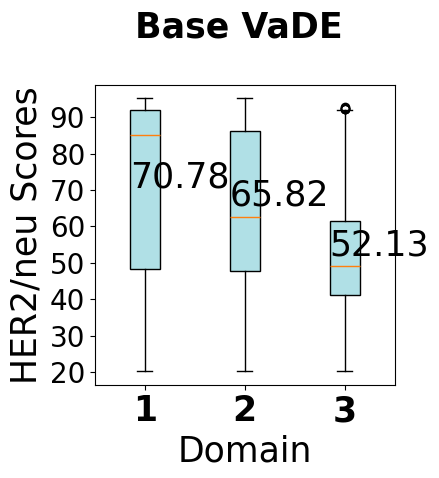

In [10]:
M1 = mean_scores_per_experiment(scores, img_locs1)
box_plot_per_domain(domain1, M1, 25, "powderblue", "Base VaDE \n ", False)

### CDVaDE results visualizations

In [11]:
domain2, _, _, img_locs2  = load_files(ex2)

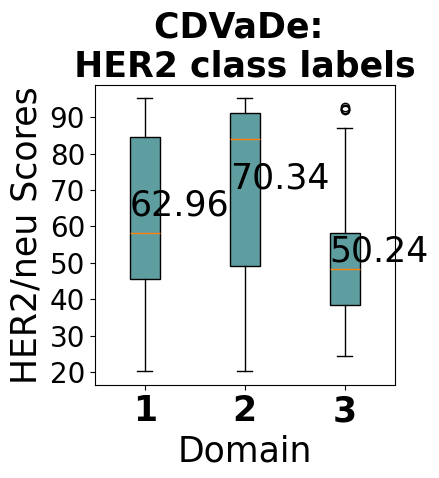

In [12]:
M2 = mean_scores_per_experiment(scores, img_locs2)
box_plot_per_domain(
    domain2,
    M2,
    25,
    "cadetblue",
    "CDVaDe: \n HER2 class labels ",
    False,
)

### DEC recults visualizations

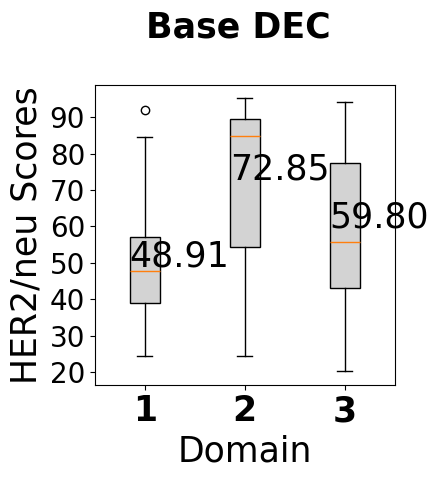

In [13]:
domain3, _, _, img_locs3  = load_files(ex3)

M3 = mean_scores_per_experiment(scores, img_locs3)
box_plot_per_domain(
    domain3,
    M3,
    25,
    "lightgrey",
    "Base DEC \n ",
    False,
)